In [14]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: white;
}
</style>

In [1]:
# </path/to>/build/bin/hipace <input>

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics
from scipy import constants

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import ConnectionPatch

import scipy.constants as phys

import sys
sys.path.append('/Users/max/HiPACE/src/hipace/tools/')
import read_insitu_diagnostics as diag

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.style.use('classic')

from scipy.integrate import quad
import scipy.special as special

In [2]:
def skinDepth(ne = 1e17):
    '''
    Calculates plasma skin depth based off plasma electron density

    Parameters
    ----------
    ne : float
        plasma electron density (in cm^-3).  Defaults to 1e17 cm^-3
    
    Returns
    -------
    kp_inv : float
        plasma skin depth in µm
    '''

    # if unit == 'SI':
    wp = 1e-3 * np.sqrt((ne * constants.e**2) / (constants.epsilon_0 * constants.m_e)) # SI
    # elif unit == 'CGS':
        # wp = np.sqrt((4 * constants.pi * ne * constants.e**2) / (constants.m_e)) # CGS
    
    kp_inv = constants.c / wp # µm
    
    return kp_inv

def gaussian(z, dz, mu = 0):
    return 1 / (dz * np.sqrt(2 * np.pi)) * np.exp(-(z - mu)**2 / (2 * dz**2))

def gaussianR(r, dr, mu = 0):
    return 1 / (dr**2 * 2 * np.pi) * np.exp(-(r - mu)**2 / (2 * dr**2))

def leftright(r0: float, r: np.ndarray) -> np.ndarray:
    left = np.heaviside(r0 - r, 0.5)
    right = np.heaviside(r - r0, 0.5)

    return left, right

def g(r0: float, r: np.ndarray, n0: float) -> np.ndarray:
    kp = skinDepth(n0) ** -1 # µm^-1
    
    r0 = abs(r0)
    r = abs(r)

    left, right = leftright(r0, r)

    # return 4 * np.pi * (np.nan_to_num(special.i0(1e6 * kp * r) * special.k0(1e6 * kp * r0), nan = 1) * left + np.nan_to_num(special.i0(1e6 * kp * r0) * special.k0(1e6 * kp * r), nan = 1) * right)
    return 4 * np.pi * ((special.i0(1e6 * kp * r) * special.k0(1e6 * kp * r0) * left + special.i0(1e6 * kp * r0) * special.k0(1e6 * kp * r) * right))

def n1(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float) -> np.ndarray:
    '''
    Parameters
    ----------
    n0 : float
        plasma electron density (in cm^-3)
    '''

    # kp = skinDepth(n0) ** -1 # µm^-1
    kp = 1e6 * skinDepth(n0) ** -1 # m^-1

    R = gaussianR(r, dr) # m^-2

    z = Nb * gaussian(xi, dz) # m^-1
    W_z = -kp * np.sin(kp * xi) # m^-1
    
    Xi = 1e-6 * np.convolve(z, W_z)[:len(xi)] # m^-1 (assuming integration measure is in microns)
    # Xi = np.convolve(z, W_z, mode = 'valid')

    n, m = len(xi), len(r)

    n_1 = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            n_1[i, j] = R[i] * Xi[j] # m^-3

    return Xi, R, n_1 / (1e6 * n0)

def Ez(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss = True, eV = False) -> np.ndarray:
    '''
    Parameters
    ----------
    eV : bool
        whether to output Ez in GeV/m (True) or V/m (False).  Defaults to False.
    '''
    kp = 1e6 * skinDepth(n0) ** -1 # m^-1

    z = Nb * gaussian(xi, dz) # m^-1
    W_z = -kp * np.cos(kp * xi) # m^-1

    # Xi = 1 / (4 * constants.pi * constants.epsilon_0) * np.convolve(z, W_z)[:len(xi)]
    Xi = 1e-6 * np.convolve(z, W_z)[:len(xi)] # m^-1 (assuming integration measure is in microns)

    if gauss:
        r_int = kp * constants.e * np.array([quad(lambda R: gaussianR(R, dr) * g(r0, R, n0) * R, 0, 1e-2)[0] for r0 in r]) # C m^-1
    else:
        r_int = kp * constants.e * np.array([quad(lambda R: 1 / (2 * np.pi * dr**2) * g(r0, R, n0) * R, 0, dr)[0] for r0 in r]) # C m^-1

    n, m = len(xi), len(r)

    E_z = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            E_z[i, j] = r_int[i] * Xi[j] # m^-2

    C = 1 / (4 * np.pi * constants.epsilon_0) # m/F = C^-1 V m

    E0 = constants.m_e * constants.c**2 * kp / constants.e # V/m
    # print(E0)

    if eV:
        return Xi, r_int, constants.e * C * E_z * 6.242e9 # 6.242*10^9 * e * V / m = GeV / m
    else:
        return Xi, r_int, C * E_z / E0

def EzR_analytic(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float) -> np.ndarray:
    r = abs(r) # m
    
    kp = 1e6 * skinDepth(n0) ** -1 # m^-1

    left, right = leftright(dr, r)

    z = Nb * gaussian(xi, dz) # m^-1
    W_z = -kp * np.cos(kp * xi) # m^-1
    
    Xi = 1e-6 * np.convolve(z, W_z)[:len(xi)] # m^-1 (assuming integration measure is in microns)

    # C = 4 * np.pi * constants.e * kp * Nb / (2 * dr) / (4 * np.pi * constants.epsilon_0)
    # C = 4 * np.pi * constants.e * kp / (2 * np.pi * dr**2) * 
    C = constants.e * kp / (2 * np.pi * dr**2 * constants.epsilon_0) # C m^-1 * m/F = C / (C/V) = V

    r_int = left * r * (special.i1(kp * r) * special.k0(kp * r) + special.i0(kp * r) * (special.k1(kp * r) - (dr / r) * special.k1(kp * dr))) + right * dr * special.i1(kp * dr) * special.k0(kp * r) # m

    n, m = len(xi), len(r)

    E_z = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            E_z[i, j] = r_int[i] * Xi[j] # SHOULD BE METERS???

    E0 = constants.m_e * constants.c**2 * kp / constants.e # V/m

    return r_int, C * E_z / E0

def Er(r: np.ndarray, dr: float, Nb: float, n0: float) -> np.ndarray:
    kp = skinDepth(n0) ** -1 # µm^-1

    sgn = np.sign(r)
    r = abs(r)

    left, right = leftright(dr, r)

    r_int = -4 * np.pi * sgn * 1e6 * dr * (left * special.k1(kp * 1e6 * dr) * special.i1(kp * 1e6 * r) + right * special.i1(kp * 1e6 * dr) * special.k1(kp * 1e6 * r))

    return r_int


In [3]:
# DOMAIN
res = 1e-6
rmin, rmax, ximin, ximax = -150e-6, 150e-6, -100e-6, 350e-6 # m
r, xi = np.arange(rmin, rmax, res), np.arange(ximin, ximax, res)

# print(r.shape, xi.shape)

# BEAM PARAMETERS
u = 'SI'
Nb = 4e8
n0 = 8e16   # cm^-3
dr = 20e-6  # m
dz = 15e-6  # m

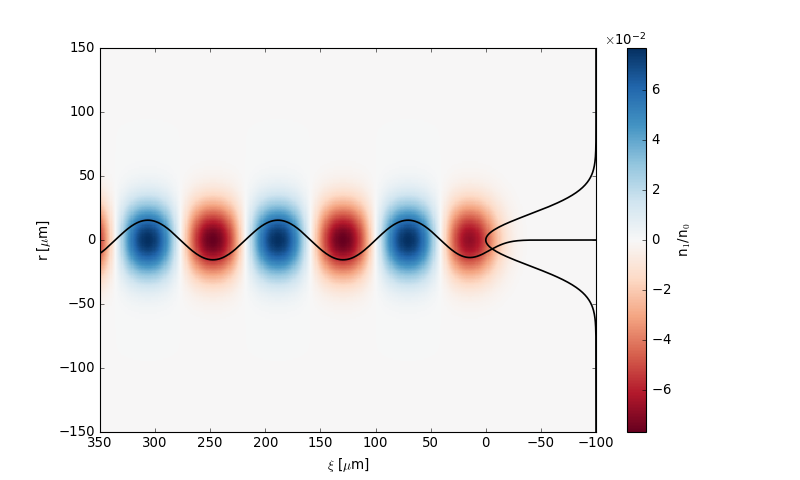

In [4]:
Xi_1, R_1, n_1 = n1(r, dr, xi, dz, Nb, n0)

plt.close()
plt.figure(4, figsize = (10, 6))
img = plt.pcolormesh(1e6 * xi, 1e6 * r, n_1, cmap = 'RdBu') #, vmin = -1e-3, vmax = 1e-3) # why did we need to multiply by 1e-5?  Where did it come from?
plt.xlim(1e6 * ximax, 1e6 * ximin)
plt.ylim(1e6 * rmin, 1e6 * rmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

plt.plot(1e6 * xi, 1e-12 * Xi_1, 'k', linewidth = 1.5)
plt.plot(1e2 * max(R_1)**-1 * R_1 - 100, 1e6 * r, 'k', linewidth = 1.5)

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'n$_1$/n$_0$')

plt.show()

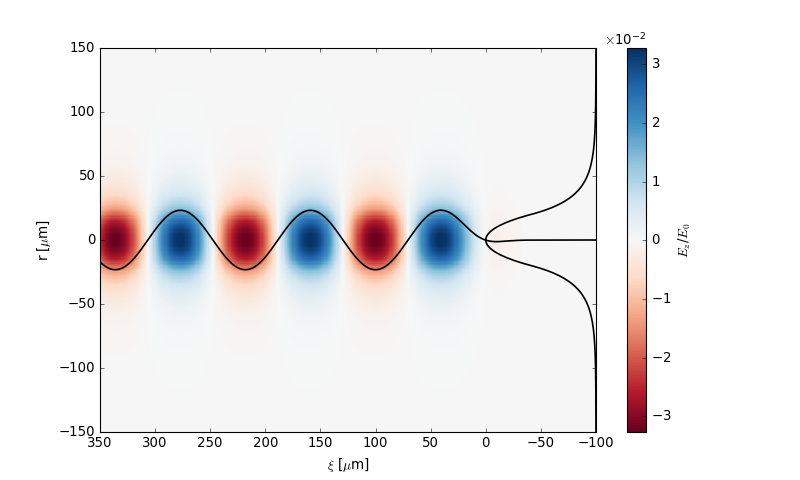

In [8]:
coord = ''
GeV = False

Xi, R, E_z = Ez(r, dr, xi, dz, Nb, n0, gauss = False, eV = GeV)
zR, E_zR = EzR_analytic(r, dr, xi, dz, Nb, n0)

plt.close()
plt.figure(5, figsize = (10, 6))

if coord == 'kp':
    kp = 1e6 * skinDepth(n0) ** -1 # m^-1

    # img = plt.pcolormesh(kp * xi, kp * r, E_z, cmap = 'RdBu') #, vmin = -5e-3, vmax = 5e-3)
    # plt.plot(100e-6 * kp * (max(R)**-1 * R - 1), kp * r, 'k', linewidth = 1.5)

    img = plt.pcolormesh(kp * xi, kp * r, E_zR, cmap = 'RdBu') # , vmin = -1e4, vmax = 1e4)
    plt.plot(100e-6 * kp * (max(R)**-1 * R - 1), kp * r, 'k', linewidth = 1.5)

    plt.plot(kp * xi, 5e-14 * Xi, 'k', linewidth = 1.5)

    plt.xlim(kp * ximax, kp * ximin)
    # plt.ylim(-3.5, 3.5)
    plt.ylim(kp * rmin, kp * rmax)
    plt.xlabel(r'$k_p\xi$')
    plt.ylabel(r'$k_p r$')
else:
    img = plt.pcolormesh(1e6 * xi, 1e6 * r, E_z, cmap = 'RdBu')
    plt.plot(1e2 * max(R)**-1 * R - 100, 1e6 * r, 'k', linewidth = 1.5)

    # img = plt.pcolormesh(1e6 * xi, 1e6 * r, E_zR, cmap = 'RdBu') # , vmin = -1e4, vmax = 1e4)
    # plt.plot(1e2 * max(zR)**-1 * zR - 100, 1e6 * r, 'k', linewidth = 1.5)

    plt.plot(1e6 * xi, 1.5e-12 * Xi, 'k', linewidth = 1.5)

    plt.xlim(1e6 * ximax, 1e6 * ximin)
    plt.ylim(1e6 * rmin, 1e6 * rmax)
    plt.xlabel(r'$\xi$ [$\mu$m]')
    plt.ylabel(r'r [$\mu$m]')

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)

if GeV:
    cb.set_label(r'$E_z$ [GeV$\cdot$m$^{-1}$]')
else:
    cb.set_label(r'$E_z$/$E_0$')

plt.show()

In [18]:
kp = skinDepth(n0) ** -1 # µm^-1

print(kp * dr * 1e6)

1.064500371190005


In [ ]:
zR, E_zR = EzR_analytic(r, dr, xi, dz, Nb, n0)
_, R, _ = Ez(r, dr, xi, dz, Nb, n0, gauss = False)
E_r = Er(r, dr, Nb, n0)

# zR = np.nan_to_num(zR)

plt.close()
plt.figure(9, figsize = (10, 6))

plt.plot(1e6 * r, E_r, 'k', linewidth = 1.5)
# plt.plot(1e6 * r, max(R)**-1 * R, 'r', linewidth = 1., label = 'Numerical')
# plt.plot( 1e6 * r, max(zR)**-1 * zR, 'k--', linewidth = 1.75, label = 'Analytic')
# plt.plot( 1e6 * r, leftright(50e-6, r)[1], 'k:', linewidth = 1.5)
# plt.plot( 1e6 * r, (R * zR), 'b', linewidth = 1.5)
# plt.plot( 1e6 * r, g(r0, r, n0) * r0 * 1e6, linewidth = 1.5)
# plt.legend()
# plt.ylim(-0.1, 1.1)
plt.xlabel('r')
plt.show()

# print(zR)

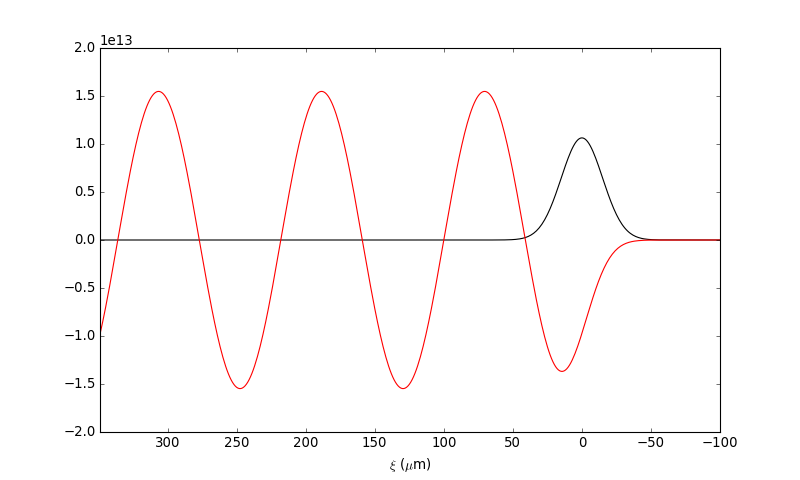

In [181]:
kp = skinDepth(n0) ** -1 # µm^-1

Z = Nb * gaussian(xi, dz)
W_z = -kp * np.sin(1e6 * kp * (xi))

plt.close()
plt.figure(6, figsize = (10, 6))
plt.plot(1e6 * xi, Z, 'k')
plt.plot(1e6 * xi, np.convolve(Z, W_z)[:len(xi)], 'r')
plt.xlabel(r'$\xi$ ($\mu$m)')
plt.xlim(1e6 * xi[-1], 1e6 * xi[0])
plt.show()

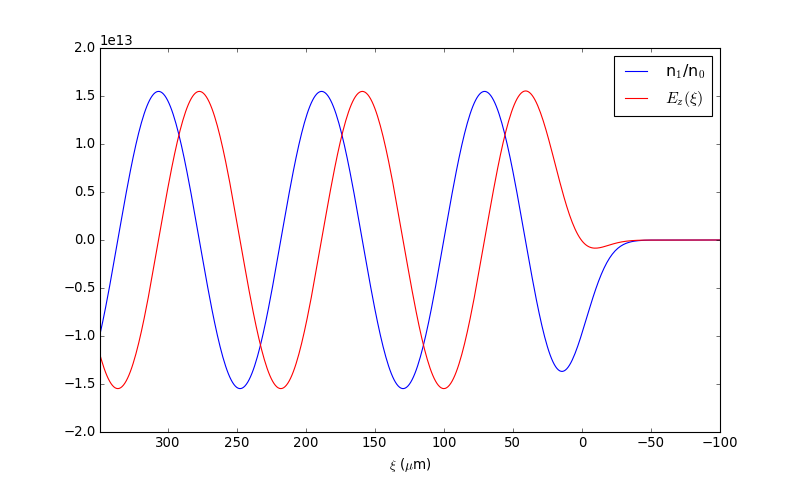

In [71]:
Xi = Ez(r, dr, xi, dz, Nb, n0)[0]

kp = skinDepth(n0) ** -1 # µm^-1

Z = Nb * gaussian(xi, dz)
W_z = -kp * np.sin(1e6 * kp * (xi))
W_Ez = -kp * np.cos(1e6 * kp * (xi))

plt.close()
plt.figure(7, figsize = (10, 6))
plt.plot(1e6 * xi, np.convolve(Z, W_z)[:len(xi)], 'b')
# plt.plot(1e6 * xi, np.convolve(Z, W_Ez)[:len(xi)], 'r')
plt.plot(1e6 * xi, Xi, 'r')
plt.xlabel(r'$\xi$ ($\mu$m)')
plt.xlim(1e6 * xi[-1], 1e6 * xi[0])
plt.legend([r'n$_1$/n$_0$', r'$E_z(\xi)$'])
# plt.yticks([])
plt.show()

In [19]:
ts = LpaDiagnostics('/Users/max/HiPACE/recovery/diags/hdf5/linear/', check_all_files = True)
beamInsitu = diag.read_file('/Users/max/HiPACE/recovery/diags/insitu/linear/reduced_beam.0000.txt')
plasmaInsitu = diag.read_file('/Users/max/HiPACE/recovery/diags/insitu/linear/reduced_plasma.0000.txt')

In [15]:
print("Available drive diagnostics:", plasmaInsitu.dtype.names)

Available drive diagnostics: ('time', 'step', 'n_slices', 'charge', 'mass', 'z_lo', 'z_hi', 'normalized_density_factor', 'is_normalized_units', '[x]', '[x^2]', '[y]', '[y^2]', '[ux]', '[ux^2]', '[uy]', '[uy^2]', '[uz]', '[uz^2]', '[ga]', '[ga^2]', 'sum(w)', 'Np', 'average', 'total')


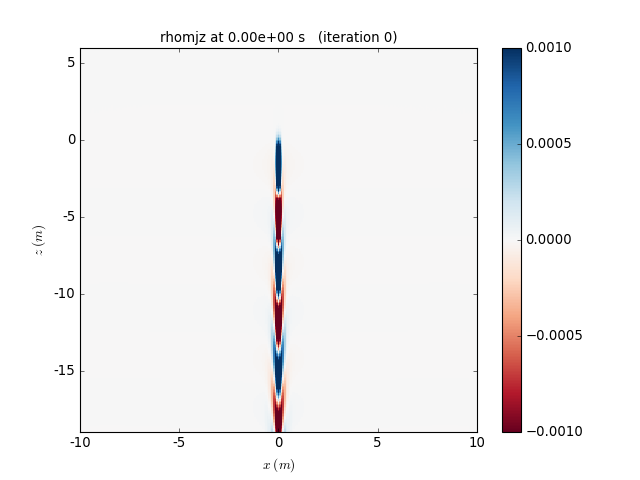

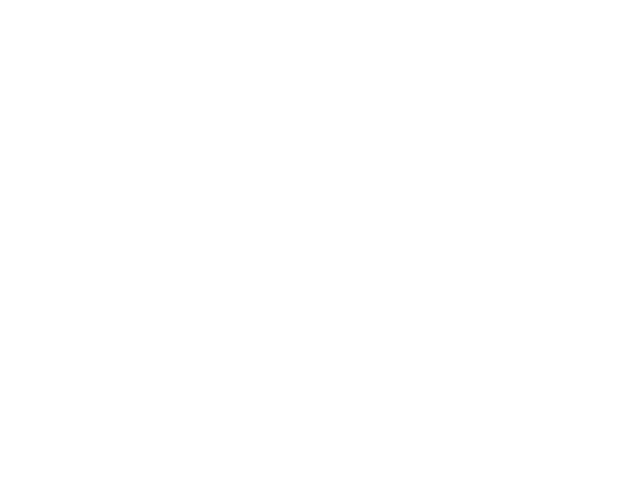

In [20]:
ts.slider()